# **Machine Learning para Business Intelligence** 
#### Profesor: Lucas Gómez Tobón

## Clase 4. Fine tuning
En las anteriores clases hemos visto como todos nuestros modelos tienen algunos hiperparámetros que el analista debe escoger, sin embargo, esta situación levanta la duda sobre ¿Cómo deberían escogerse estos valores? Ciertamente no existe ningún *silver bullet* en donde un valor de hiperparámetro sirva para todos los problemas, entonces debemos diseñar una estrategia para encontrar la mejor configuración para correr nuestro modelo.

Al proceso de encontrar el mejor modelo posible calibrando variables e hiperparámetros se le conoce como **fine tuning**. En la clase de hoy aprenderemos:
- ¿Cómo se deben diseñar las evaluaciones de nuestros modelos para que las métricas reflejen el desempeño de nuestro modelo en la vida real?
- ¿Qué métricas existen para evaluar nuestros modelos? ¿Cuáles métricas debería usar?
- ¿Cómo encontrar los mejores hiperparámetros de un modelo?
- Entender el trade-off entre sesgo y varianza

Comencemos haciendo un ejercicio con el modelo de K-Vecinos Más Cercanos. De entrada ya vimos que debemos escoger un valor de $K$ a la hora de ejecutar nuestro modelo. Veamos cómo cambian nuestros resultados para diferentes $K$ y aprendamos como seleccionar el $K$ óptimo.

Vamos a trabajar con datos simulados en donde vamos a crear 10 mil puntos que se distribuyen uniformemente entre 0 y 1 para dos variables $x_1$ y $x_2$.

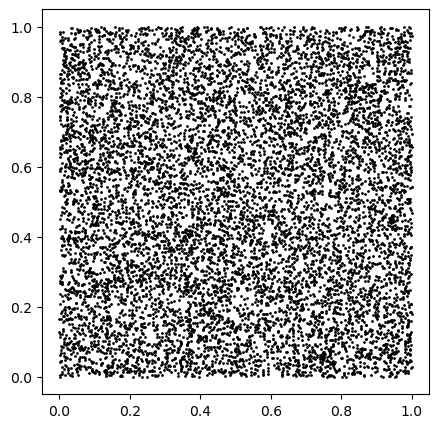

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Número de observaciones
n = 10000

# Definimos semilla
np.random.seed(666)

# Crear variables x1 y x2
x1 = np.random.uniform(size = n)
x2 = np.random.uniform(size = n)

# Visualizamos nuestros resultados
plt.subplots(figsize = (5, 5))
plt.scatter(x1, x2, s = 1, c = "black")

Ahora vamos a crear un dataframe con la información de todos los puntos. Adicionalmente vamos a crear un modelo que divida los datos entre morados y amarillos dependiendo si están por encima o debajo de la diagonal.

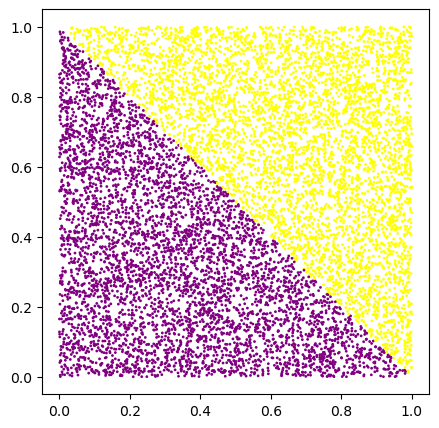

In [3]:
import pandas as pd
from matplotlib.colors import ListedColormap

df = pd.DataFrame({"x1": x1, "x2": x2})
# Si la suma entre ambas coordenadas es mayor a 1, significa que está por encima de la diagonal
df["Categoría"] = df.sum(axis = 1) > 1

# Visualizamos nuestros resultados
cmap_py = ListedColormap(["purple", "yellow"])
plt.subplots(figsize = (5, 5))
plt.scatter(df["x1"], df["x2"], s = 1, c = df["Categoría"], cmap = cmap_py)

Ahora vamos a generar algo de ruido en nuestro modelo, vamos a cambiar el color del **25%** de nuestras observaciones de forma arbitraria.

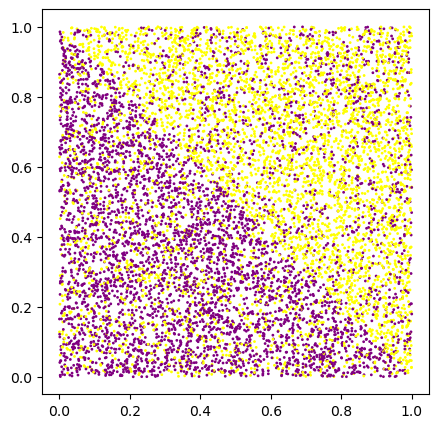

In [4]:
# Definimos semilla
np.random.seed(123)
# Utilizamos la distribución binomial para que nos seleccione aleatoriamente el 25% de las observaciones
indices = np.random.binomial(n = 1, p = 0.25, size = n) == 1
# Cambiamos el color
df.loc[indices, "Categoría"] = ~df.loc[indices, "Categoría"]

# Visualizamos nuestros resultados
plt.subplots(figsize = (5, 5))
plt.scatter(df["x1"], df["x2"], s = 1, c = df["Categoría"], cmap = cmap_py)

Ahora vamos a tomar una submuestra del 10% de nuestros datos, es decir, de solo 1000 observaciones para entrenar nuestro modelo.

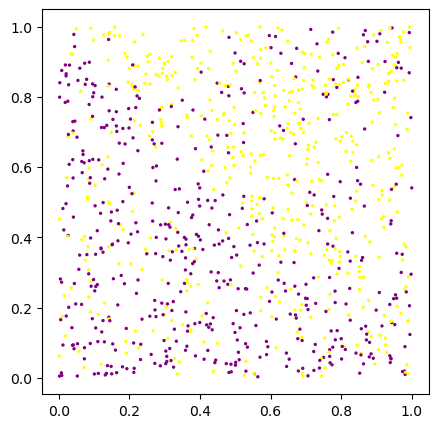

In [5]:
df_sample = df.sample(1000, random_state = 666)

# Visualizamos nuestros resultados
plt.subplots(figsize = (5, 5))
plt.scatter(df_sample["x1"], df_sample["x2"], s = 2, c = df_sample["Categoría"], cmap = cmap_py)

Ahora usemos el modelo de KNN para tratar de predecir si un punto debe ser amarillo o morado según su posición en el gráfico. Para jugar probemos con 3 diferentes valores de $K$ y veamos por donde va la cosa.

In [6]:
# En caso de tener problemas:
# pip install -U scikit-learn --user

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import DecisionBoundaryDisplay

# Como vamos a utilizar el paquete sklearn, debemos dividir nuestros datos en X y y
X = df_sample[["x1", "x2"]]
y = df_sample["Categoría"]

# Modelo con 5 vecinos
neigh5 = KNeighborsClassifier(n_neighbors = 5)
neigh5.fit(X, y)

# Modelo con 15 vecinos
neigh15 = KNeighborsClassifier(n_neighbors = 15)
neigh15.fit(X, y)

# Modelo con 25 vecinos
neigh25 = KNeighborsClassifier(n_neighbors = 25)
neigh25.fit(X, y)

KNeighborsClassifier(n_neighbors=25)

In [8]:
# ¿Cómo harían esto con un loop?
# Existe una regla no escrita en programación que dice que si uno debe copiar y pegar el mismo código más de 2 veces, lo
# correcto es hacer un loop
modelos = {}
for k in [5, 15, 25]:
    neigh = KNeighborsClassifier(n_neighbors = k)
    neigh.fit(X, y)
    modelos["neigh" + str(k)] = neigh

Text(0.5, 1.0, 'KNN con K = 5')

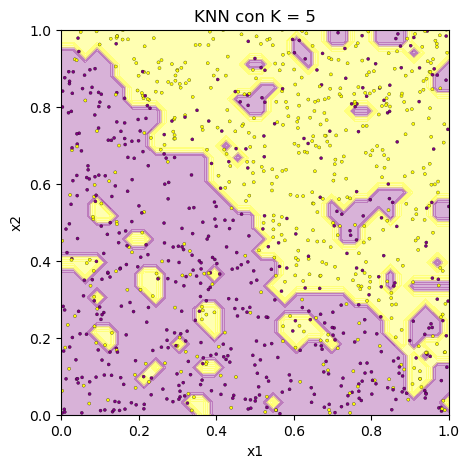

In [9]:
fig, ax = plt.subplots(figsize = (5, 5))

disp = DecisionBoundaryDisplay.from_estimator(estimator = modelos["neigh5"],  X = X, cmap = cmap_py,
    ax = ax, response_method = "predict", plot_method = "contourf",
    xlabel = "x1", ylabel = "x2", alpha = 0.3)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plt.scatter(df_sample["x1"], df_sample["x2"], s = 5, c = df_sample["Categoría"], cmap = cmap_py, 
            edgecolor = "k", linewidths = 0.2)
plt.title("KNN con K = 5")

Text(0.5, 1.0, 'KNN con K = 15')

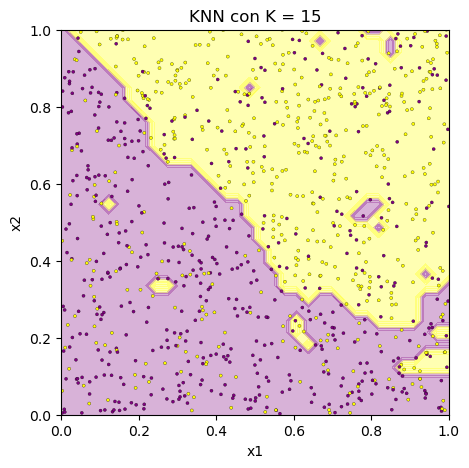

In [10]:
fig, ax = plt.subplots(figsize = (5, 5))

disp = DecisionBoundaryDisplay.from_estimator(estimator = modelos["neigh15"],  X = X, cmap = cmap_py,
    ax = ax, response_method = "predict", plot_method = "contourf",
    xlabel = "x1", ylabel = "x2", alpha = 0.3)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plt.scatter(df_sample["x1"], df_sample["x2"], s = 5, c = df_sample["Categoría"], cmap = cmap_py, 
            edgecolor = "k", linewidths = 0.2)
plt.title("KNN con K = 15")

Text(0.5, 1.0, 'KNN con K = 25')

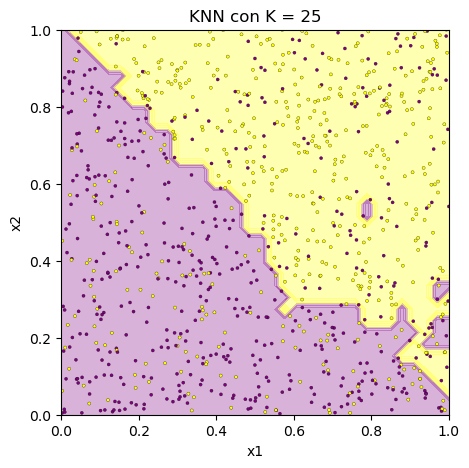

In [11]:
fig, ax = plt.subplots(figsize = (5, 5))

disp = DecisionBoundaryDisplay.from_estimator(estimator = modelos["neigh25"],  X = X, cmap = cmap_py,
    ax = ax, response_method = "predict", plot_method = "contourf",
    xlabel = "x1", ylabel = "x2", alpha = 0.3)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plt.scatter(df_sample["x1"], df_sample["x2"], s = 5, c = df_sample["Categoría"], cmap = cmap_py, 
            edgecolor = "k", linewidths = 0.2)
plt.title("KNN con K = 25")

En la medida que el número de vecinos aumenta, nuestra frontera de decisión se vuelve menos compleja. Esto quiere decir que nuestro modelo se reduce en varianza. Para hacer evidente esto, repetiremos el ejercicio pero cambiando la muestra de los datos.

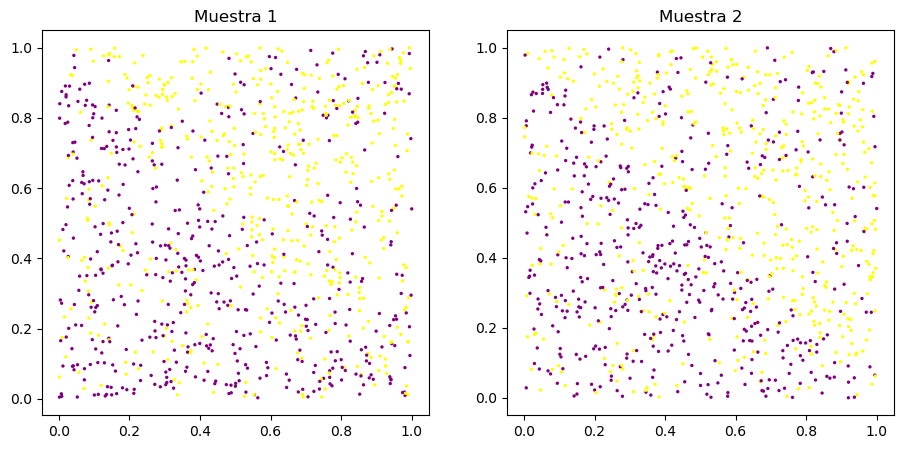

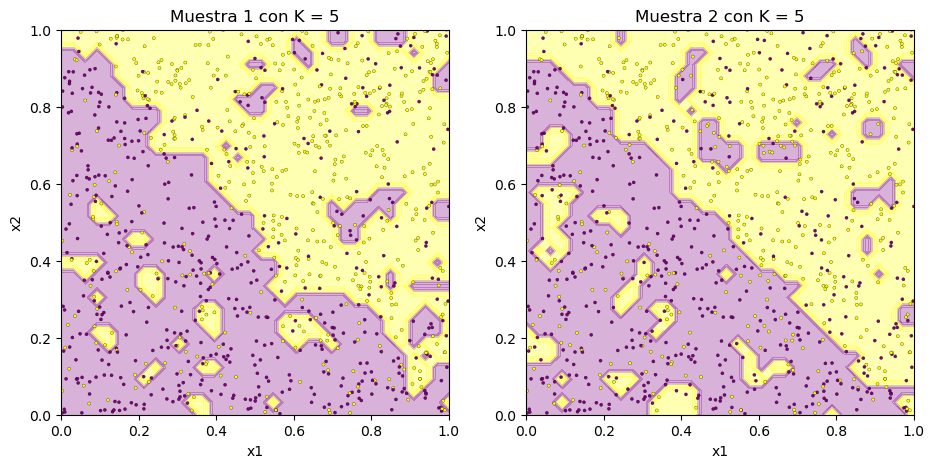

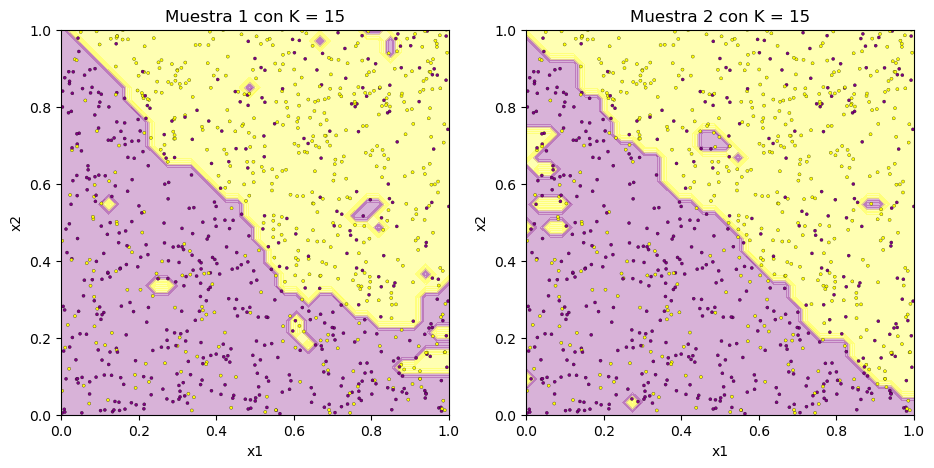

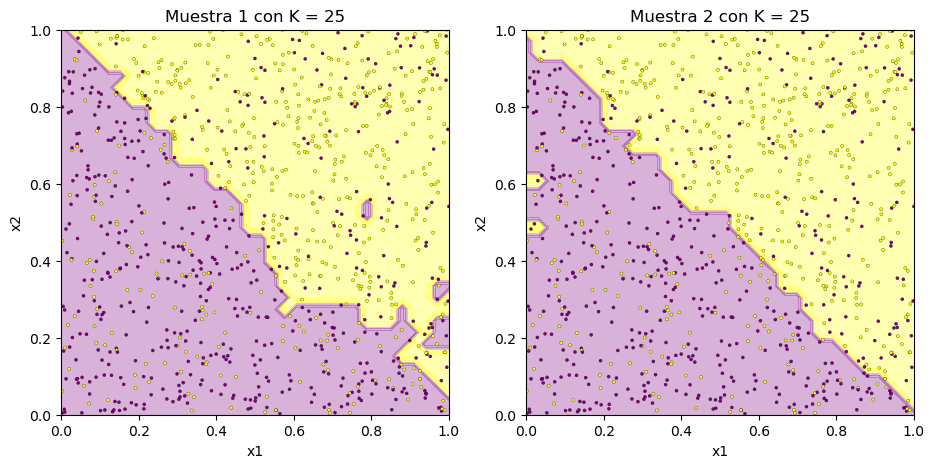

In [12]:
df_sample2 = df.sample(1000, random_state = 123)

# Visualizamos nuestros resultados
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (11, 5))
axs[0].scatter(df_sample["x1"], df_sample["x2"], s = 2, c = df_sample["Categoría"], cmap = cmap_py)
axs[0].set_title("Muestra 1")
axs[1].scatter(df_sample2["x1"], df_sample2["x2"], s = 2, c = df_sample2["Categoría"], cmap = cmap_py)
axs[1].set_title("Muestra 2")

modelos2 = {}
X2 = df_sample2[["x1", "x2"]]
y2 = df_sample2["Categoría"]
for k in [5, 15, 25]:
    neigh = KNeighborsClassifier(n_neighbors = k)
    neigh.fit(X2, y2)
    modelos2["neigh" + str(k)] = neigh

    fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (11, 5))
    # Ploteamos la frontera de la muestra 1
    disp = DecisionBoundaryDisplay.from_estimator(estimator = modelos["neigh" + str(k)],  X = X, cmap = cmap_py,
        ax = axs[0], response_method = "predict", plot_method = "contourf",
        xlabel = "x1", ylabel = "x2", alpha = 0.3)
    axs[0].set_xlim(0, 1)
    axs[0].set_ylim(0, 1)
    axs[0].scatter(df_sample["x1"], df_sample["x2"], s = 5, c = df_sample["Categoría"], cmap = cmap_py, 
                   edgecolor = "k", linewidths = 0.2)
    axs[0].set_title("Muestra 1 con K = " + str(k))

    # Ploteamos la frontera de la muestra 2
    disp = DecisionBoundaryDisplay.from_estimator(estimator = modelos2["neigh" + str(k)],  X = X, cmap = cmap_py,
        ax = axs[1], response_method = "predict", plot_method = "contourf",
        xlabel = "x1", ylabel = "x2", alpha = 0.3)
    axs[1].set_xlim(0, 1)
    axs[1].set_ylim(0, 1)
    axs[1].scatter(df_sample["x1"], df_sample["x2"], s = 5, c = df_sample["Categoría"], cmap = cmap_py, 
                   edgecolor = "k", linewidths = 0.2)
    axs[1].set_title("Muestra 2 con K = " + str(k))

En Machine Learning entendemos que la **varianza de nuestro modelo** es que tanto cambian los resultados de este cuando se cambia la muestra. En este caso, vemos que entre más pequeño es $K$ más varianza tiene el modelo porque las fronteras de decisión son más disimiles entre ambas muestras, en cambio, cuando $K$ crece, las fronteras de decisión tienden a ser más estables, luego el modelo tiene menos varianza.

Por otro lado, es claro que cuando el número de vecinos es pequeño, la cantidad de observaciones mal clasificadas es poco pues nuestra frontera se está ajustando más a nuestra muestra. Aquí es claro que el **sesgo** se reduce cuando $k$ se hace pequeño.

De aquí nace el **trade-off entre sesgo y varianza**. Note que cuando $k$ es pequeño nuestro sesgo se reduce pero la varianza aumenta y viceversa. Entonces, ¿Cuál es el valor óptimo de $K$ entonces? ¿Cuánto sesgo y cuánta varianza debo tener? 

Para responder esta pregunta tenemos que entender ¿Qué es el error irreducible? para ilustrar este punto, vamos a dividir nuestra base de datos en dos: train y test.

In [13]:
from sklearn.model_selection import train_test_split


# Dividimos nuestra base de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 50)
# Creamos una lista de K posibles
vecinos = list(range(2, 21, 2)) + list(range(21, 51, 10)) + list(range(50, 401, 20)) + [500, 600]

errores_insample = []
errores_outsample = []
for k in vecinos:
    neigh = KNeighborsClassifier(n_neighbors = k)
    neigh.fit(X_train, y_train)
    y_hat_insample = neigh.predict(X_train)
    y_hat_outsample = neigh.predict(X_test)

    error_insample = (y_hat_insample != y_train).mean()
    errores_insample.append(error_insample)
    error_outsample = (y_hat_outsample != y_test).mean()
    errores_outsample.append(error_outsample)

resultados = pd.DataFrame({"K": vecinos, "Error de entrenamiento": errores_insample, "Error de prueba": errores_outsample})

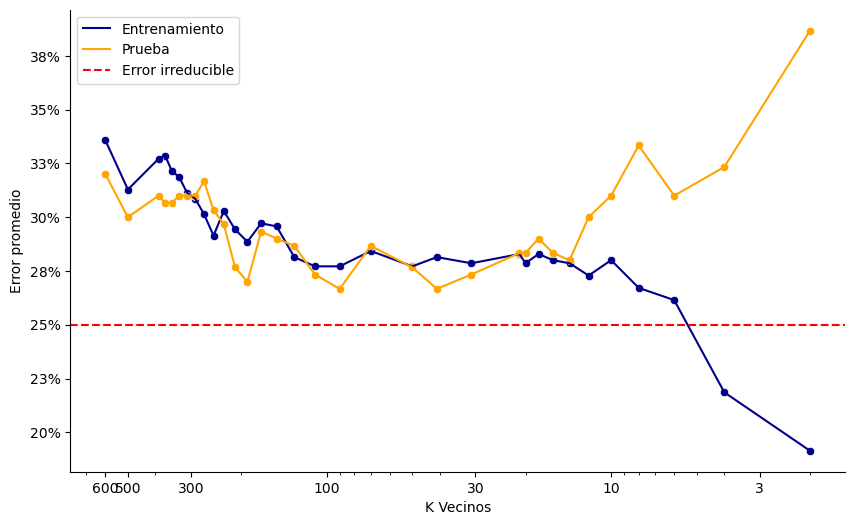

In [14]:
import seaborn as sns

fig, ax = plt.subplots(figsize = (10, 6), dpi = 100)
sns.despine()

sns.lineplot(data = resultados, x = "K", y = "Error de entrenamiento", ax = ax, color = "darkblue")
sns.scatterplot(data = resultados, x = "K", y = "Error de entrenamiento", ax = ax, color = "darkblue")
sns.lineplot(data = resultados, x = "K", y = "Error de prueba", ax = ax, color = "orange")
sns.scatterplot(data = resultados, x = "K", y = "Error de prueba", ax = ax, color = "orange")
ax.axhline(y = 0.25, color = "red", linestyle = "--", label = "Error irreducible")

ax.legend(handles = ax.lines, labels = ["Entrenamiento", "Prueba", "Error irreducible"])

ax.set_xlabel("K Vecinos")
ax.set_ylabel("Error promedio")
ax.invert_xaxis()
ax.set_xscale("log")
ax.set_xticks([600, 500, 300, 100, 30, 10, 3])
ax.set_xticklabels([600, 500, 300, 100, 30, 10, 3])
ax.yaxis.set_major_formatter("{x:.0%}")

En la gráfica tenemos 2 líneas, una amarilla y otra azul, cada una nos dice cuál fue el porcentaje de error que tuvo el modelo para diferentes niveles de $K$. La linea azul refleja cuánto se equivocó el modelo dentro de la muestra de entrenamiento donde se puede ver que entre más pequeño sea el número de vecinos ($K$) menor es el error. Sin embargo, note que lo mismo no pasa cuando se analiza el desempeño del modelo en la muestra de prueba (linea amarilla). En este caso, el modelo tiene un punto mínimo de error al rededor de 100 y 30 vecinos, en donde si nos alejamos de esos valores de referencia, el error crece. 

De hecho, podemos ver que el error nunca es menor al 25%. A esto se le conoce como el error irreducible. La línea roja marca el ruido que nosotros le añadimos a los datos al comienzo del ejercicio y, dado que este es completamente aleatorio, ningún modelo podrá descifrarlo.

Esta gráfica muestra perfectamente la relación entre sesgo y varianza. Cuando $K$ es muy pequeño, el sesgo es pequeño porque podemos predecir muy bien nuestra muestra, sin embargo, cuando se cambia la muestra, el modelo es muy diferente, luego la varianza es alta. Por el lado contrario, cuando $K$ es muy grande, la varianza es muy baja pero el sesgo muy alto. En ese orden de ideas, deberíamos encontrar un modelo que nos optimice una métrica de error **por fuera** de nuestra muestra y que nos garantice que el error de entrenamiento y prueba sea muy similar entre sí.

Antes de entrar a explicar cómo podemos optimizar la métrica de error fuera de muestra, vamos a dejar acá una explicación teórica sobre el error irreducible y el trade off entre varianza y sesgo.

### Nota Teórica
Imagine que tenemos dos variables $(X, Y) \in \mathbb{R}^p \times \mathbb{R}$ y en nuestro ejercicio queremos predecir $Y$ a partir de alguna función $f(X)$.

Por predecir nosotros entendemos concretamente que $f(X)$ se aproxime lo mejor posible a $Y$. Por mejor posible podemos usar diferentes definiciones, para este ejemplo usaremos el **error cuadrático**:
$$L(Y,f(X))\triangleq(Y-f(X))^2 $$
Por ende, nuestro objetivo en los ejercicios de aprendizaje supervisado será minimizar esa función de pérdida en promedio. A esto lo llamamos **riesgo**:
$$R(Y, f(X)) \triangleq \mathbb{E}[L(Y, f(X))] = \mathbb{E}_{X, Y}[(Y - f(X)) ^ 2]$$

Ahora bien, a partir de unos datos dados $\mathcal{D} = (x_i, y_i) \in \mathbb{R}^p \times \mathbb{R}$ nuestro objetivo será encontrar alguna $\hat f$ que sea una buena estimación de $f$.

#### Error reducible e irreducible
Ahora suponga que obtuvimos nuestra $\hat f$ y queremos saber qué tan bien estimamos $f$. Para tal fin definimos el valor esperado del error de predicción como: 
$$\text{EPE}\left(Y, \hat{f}(X)\right) \triangleq \mathbb{E}_{X, Y, \mathcal{D}} \left[  \left( Y - \hat{f}(X) \right)^2 \right]$$
Note que el valor esperado se define tanto sobre $X, Y$ como sobre $\mathcal{D}$. Como no conocemos el mecanismo generador de los datos real, nuestra estimación de $\hat f$ depende de nuestra muestra de los datos $\mathcal{D}$. De hecho, podríamos hacer explicito esto con la notación $\hat f(X, \mathcal{D})$ pero por fines prácticos nos vamos a quedar solo con $\hat f$ para hacer alusión a esa expresión.

El valor esperado del error de predicción se puede partir en dos partes cuando condicionamos en $X$:
$$\text{EPE}\left(Y, \hat{f}(x)\right) = 
\mathbb{E}_{Y \mid X, \mathcal{D}} \left[  \left(Y - \hat{f}(X) \right)^2 \mid X = x \right] = 
\underbrace{\mathbb{E}_{\mathcal{D}} \left[  \left(f(x) - \hat{f}(x) \right)^2 \right]}_\textrm{Error reducible} + 
\underbrace{\mathbb{V}_{Y \mid X} \left[ Y \mid X = x \right]}_\textrm{Error irreducible}$$
Note las siguientes 3 cosas:

1. Calculamos el valor esperado del error de predicción para una $Y$ aleatoria dado un $x$ fijo y un $\hat f$ aleatorio. Esto porque el valor esperado es sobre $Y | X, \mathcal{D}$. Por tal motivo nuestra función $\hat f$ es aletorio dependiendo de la muestra de datos $\mathcal{D}$.
2. El primer término del error lo llamamos el **Error reducible** el cual es el error cuadrático esperado de la estimación $f(x)$ usando $\hat f(x)$ en un punto dado $x$. Lo único aleatorio acá es la muestra $\mathcal{D}$ con la que obtenemos $\hat f(x)$ (tanto $f$ como $x$ están fijas). Usualmente se le conoce a esto como el **Mean squeared error (MSE)**
$$\text{MSE}\left(f(x), \hat{f}(x)\right) \triangleq 
\mathbb{E}_{\mathcal{D}} \left[  \left(f(x) - \hat{f}(x) \right)^2 \right]$$
3. El segundo término lo llamamos el **Error irreducible** es la varianza de $Y$ dado $X=x$. Esencialmente esto es ruido que no deseamos que nuestro modelo aprenda. Llamamos a esto el **Error de Bayes**.

Dado que solo tenemos control sobre el error reducible, nos vamos a tratar de concentrar en este aspecto.

#### Descomposición Sesgo - Varianza
Recordemos las definiciones de sesgo y varianza:
$$\text{Sesgo}(\hat{\theta}) \triangleq \mathbb{E}\left[\hat{\theta}\right] - \theta$$
$$\mathbb{V}(\hat{\theta}) = \text{var}(\hat{\theta}) \triangleq \mathbb{E}\left [ ( \hat{\theta} -\mathbb{E}\left[\hat{\theta}\right] )^2 \right]$$
A partir de estas podemos descomponer el MSE en estos dos componentes:
$$\text{MSE}\left(f(x), \hat{f}(x)\right) = 
\mathbb{E}_{\mathcal{D}} \left[  \left(f(x) - \hat{f}(x) \right)^2 \right] = 
\underbrace{\left(f(x) - \mathbb{E} \left[ \hat{f}(x) \right]  \right)^2}_{\text{Sesgo}^2 \left(\hat{f}(x) \right)} +
\underbrace{\mathbb{E} \left[ \left( \hat{f}(x) - \mathbb{E} \left[ \hat{f}(x) \right] \right)^2 \right]}_{\text{var} \left(\hat{f}(x) \right)}$$
En resumen:
$$\text{MSE}\left(f(x), \hat{f}(x)\right) = \text{bias}^2 \left(\hat{f}(x) \right) + \text{var} \left(\hat{f}(x) \right)$$
Lo idea sería tener un sesgo de cero y muy baja varianza, sin embargo esto en la práctica no es fácil de lograr. En general hablamos de un **trade-off entre sesgo y varianza**: entre más pequeño sea el sesgo de nuestro modelo, mayor será la varianza y entre más pequeña sea la varianza, mayor será el sesgo. Esto está muy relacionado con la complejidad del modelo, entre más complejo sea el modelo, menor sesgo se tendrá pero se pagará con una mayor varianza.

Si suponemos que la varianza del error es igual a $\sigma$ podríamos recapitular lo que hemos aprendido hoy en una sola ecuación:
$$\text{EPE}\left(Y, \hat{f}(x)\right) =  
\underbrace{\text{bias}^2\left(\hat{f}(x)\right) + \text{var}\left(\hat{f}(x)\right)}_\textrm{Error reducible} + \underbrace{\sigma^2}_\textrm{Error irreducible}$$

#### Derivación de la fórmula del error reducible y irreducible
Recuerde que $f$ y $\hat f$ son constantes, luego $\mathbb{E}[c] = c$. Además suponemos que el error es simétrico alrededor de cero $\mathbb{E}[\epsilon] = 0$, entonces $\textrm{Var}(\epsilon) = E\left[\left(\epsilon - E\left[\epsilon\right]\right)^2\right]$.

\begin{align}
\mathbb{E}(Y - \hat Y)^2 &= \mathbb{E}\left[f(X) + \epsilon - \hat f(X)\right]^2 \\
 &= \mathbb{E}\left[\left(f(X) - \hat f(X)\right)+\epsilon\right]^2 \\
 &= \mathbb{E}\left[\left(f(X) - \hat f(X)\right)^2+2\epsilon\left(f(X) - \hat f(X)\right)+\epsilon^2\right] \\
 &= \mathbb{E}\left[\left(f(X) - \hat f(X)\right)^2\right]+\mathbb{E}\left[2\epsilon\left(f(X) - \hat f(X)\right)\right]+\mathbb{E}\left[\epsilon^2\right] \\
 &=\left(f(X) - \hat f(X)\right)^2+0+\mathbb{E}\left[\epsilon^2\right]
\end{align}

### Encontrar el mejor modelo
Para encontrar el mejor modelo primero debemos definir una técnica para evaluar el modelo. Dado que aprendimos que los modelos pueden no desempeñarse igual en las muestras de entrenamiento y en producción por culpa del *overfitting*, necesitamos recurrir a una técnica que permita evaluar el modelo de forma robusta. La técnica más común para evaluar un modelo se conoce como **K-Fold Cross Validation**.

#### K-Fold Cross Validation
La técnica de Cross Validation implica dividir los datos en $k$ partes iguales (conocidas como k-folds), donde k es un número predeterminado. Luego, se entrena el modelo en $k-1$ de estas partes y se prueba en la parte restante. Este proceso se repite $k$ veces, de manera que cada parte se utiliza como conjunto de prueba una vez. Los resultados de las $k$ iteraciones se promedian para dar una medida general del rendimiento del modelo.

La técnica de Cross Validation ayuda a prevenir el sobreajuste, ya que evalúa el rendimiento del modelo en datos no utilizados en el entrenamiento, lo que ayuda a identificar problemas de generalización. Además, la técnica puede ayudar a seleccionar el mejor modelo o conjunto de hiperparámetros, ya que se pueden comparar los resultados de diferentes modelos y ajustes de parámetros utilizando los mismos conjuntos de datos.

<center>
<img src = "img/KFCV.png" width = 400>
</center>

Para hacer ejercicios prácticos de Cross Validation vamos a usar la base de la clase pasada. Esta base tiene información sobre los precios de las casas en Boston y algunas covariables:

- CRIM: tasa de criminalidad per cápita por ciudad
- ZN: proporción de suelo residencial zonificado para lotes de más de 25,000 pies cuadrados.
- INDUS: proporción de acres comerciales no minoristas por ciudad
- CHAS: variable ficticia del río Charles (= 1 si el tramo limita con el río; 0 en caso contrario)
- NOX: concentración de óxidos nítricos (partes por 10 millones)
- RM: número medio de habitaciones por vivienda
- AGE: proporción de unidades ocupadas por sus propietarios construidas antes de 1940
- DIS: distancias ponderadas a cinco centros de empleo de Boston
- RAD: índice de accesibilidad a las carreteras radiales
- TAX: tasa de impuesto a la propiedad de valor total por cada $10,000
- PTRATIO: ratio alumno-profesor por municipio
- B: 1000(Bk - 0.63)^2 donde Bk es la proporción de negros por ciudad
- LSTAT: % de la población pobres
- MEDV: valor medio de las viviendas ocupadas por sus propietarios en miles de dólares

In [15]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"

raw_df = pd.read_csv(data_url, sep = "\s+", skiprows = 22, header = None)
raw_df

,0,1,2,3,4,5,6,7,8,9,10
0,0.00632,18.00,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3
1,396.90000,4.98,24.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.02731,0.00,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8
3,396.90000,9.14,21.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.02729,0.00,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8
...,...,...,...,...,...,...,...,...,...,...,...
1007,396.90000,5.64,23.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1008,0.10959,0.00,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0
1009,393.45000,6.48,22.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1010,0.04741,0.00,11.93,0.0,0.573,6.030,80.8,2.5050,1.0,273.0,21.0


In [16]:
data = pd.DataFrame(np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]]))
target = pd.DataFrame({"MEDV": raw_df.values[1::2, 2]})
target

,MEDV
0,24.0
1,21.6
2,34.7
3,33.4
4,36.2
...,...
501,22.4
502,20.6
503,23.9
504,22.0


In [17]:
data.columns = ["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"]

In [18]:
data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


In [19]:
boston = pd.concat([data, target], axis = 1)
boston

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


Estudiemos la relación entre el precio (`MEDV`) y el porcentaje de pobres (`LSTAT`)

<AxesSubplot:xlabel='LSTAT', ylabel='MEDV'>

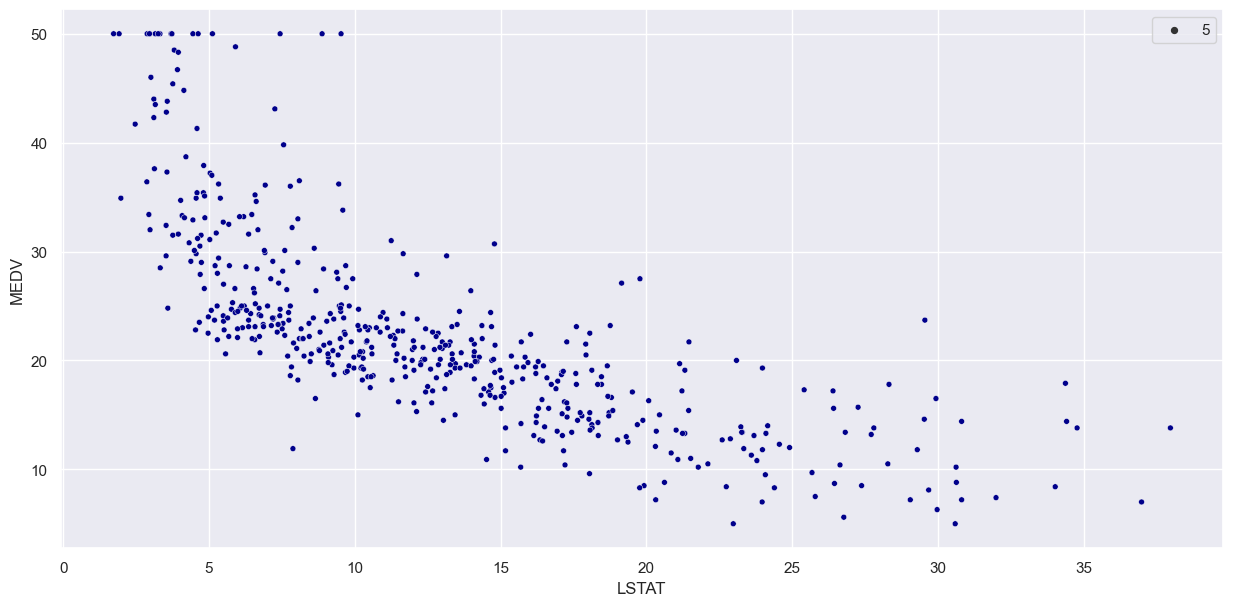

In [20]:
sns.set()
fig, ax = plt.subplots(figsize = (15, 7))
sns.scatterplot(data = boston, x = "LSTAT", y = "MEDV", color = 'darkblue', size = 5)

In [21]:
from sklearn.preprocessing import PolynomialFeatures

# Creemos 3 diferentes modelos
y = boston["MEDV"]
X = boston[["LSTAT"]]

poly1 = PolynomialFeatures(degree = 1)
poly2 = PolynomialFeatures(degree = 2)
poly5 = PolynomialFeatures(degree = 5)

X1 = poly1.fit_transform(X)
X2 = poly2.fit_transform(X)
X5 = poly5.fit_transform(X)

In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

# Ahora vamos a entrenar los modelos en diferentes muestras de datos haciendo uso de Cross Validation

# Creamos la carcasa del modelo
reg = LinearRegression()

# Hacemos Cross Validation
# Para revisar las métricas disponibles podemos revisar https://scikit-learn.org/stable/modules/model_evaluation.html
cv1 = cross_val_score(reg, X1, y, cv = 10, scoring = "neg_mean_absolute_error", n_jobs = None)
cv2 = cross_val_score(reg, X2, y, cv = 10, scoring = "neg_mean_absolute_error", n_jobs = None)
cv5 = cross_val_score(reg, X5, y, cv = 10, scoring = "neg_mean_absolute_error", n_jobs = None)

In [23]:
resultados = pd.DataFrame({"Folds": range(1,11), "Polinomio 1": cv1, "Polinomio 2": cv2, "Polinomio 5": cv5})
resultados = resultados.melt(id_vars = "Folds")

<AxesSubplot:xlabel='variable', ylabel='value'>

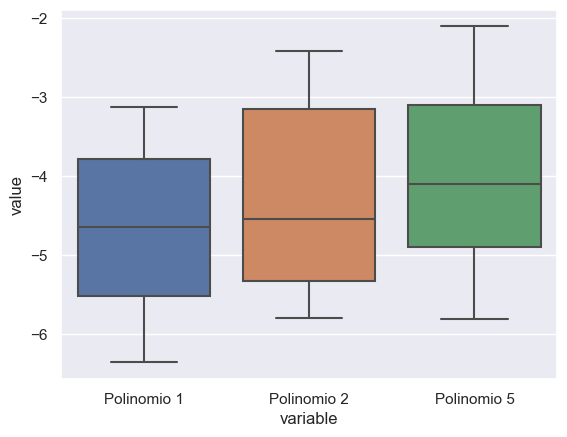

In [24]:
sns.boxplot(data = resultados, x = "variable", y = "value")

In [25]:
np.round(np.mean(cv1), 2)

-4.69

In [26]:
np.round(np.mean(cv2), 2)

-4.29

In [27]:
np.round(np.mean(cv5), 2)

-3.99

El error promedio se hizo más pequeño en la medida que aumenté mi grado del polinomio. Ahora, ¿Cómo hacemos para extender este ejercicio muchas más veces?

#### Grid Search CV
Grid Search es una técnica de optimización de parámetros utilizada en aprendizaje automático y minería de datos para encontrar los mejores hiperparámetros para un modelo. Los hiperparámetros son configuraciones que no se aprenden automáticamente durante el entrenamiento del modelo, sino que se establecen antes del entrenamiento y pueden afectar significativamente el rendimiento del modelo.

El proceso de Grid Search implica especificar un rango de valores para cada hiperparámetro y luego crear una "cuadrícula" de todas las posibles combinaciones de valores de hiperparámetros. Luego, se entrena y evalúa el modelo para cada combinación de valores de hiperparámetros en la cuadrícula. Finalmente, se selecciona la combinación de hiperparámetros que produjo el mejor rendimiento en el conjunto de validación.

Grid Search es una técnica simple pero efectiva para encontrar la mejor combinación de hiperparámetros para un modelo. Sin embargo, puede ser computacionalmente costoso cuando se trabaja con grandes conjuntos de datos y modelos complejos con muchos hiperparámetros.

<center>
<img src = "img/grid_search.png" width = 400>
</center>

In [28]:
from sklearn.pipeline import make_pipeline
# Creamos un pipeline
PolynomialRegression = make_pipeline(PolynomialFeatures(),
                                     LinearRegression())

In [29]:
print(PolynomialRegression)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])


In [30]:
from sklearn.model_selection import GridSearchCV

parametros = {'polynomialfeatures__degree': range(1, 20)}

modelo_cv = GridSearchCV(estimator = PolynomialRegression, param_grid = parametros, 
                         scoring = "neg_mean_absolute_error", 
                         n_jobs = None, cv = 5, return_train_score = True)

modelo_cv.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'polynomialfeatures__degree': range(1, 20)},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [31]:
cv_results = pd.DataFrame(modelo_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_polynomialfeatures__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.004332,0.001308,0.001404,0.000491,1,{'polynomialfeatures__degree': 1},-4.182007,-4.384257,-6.006667,-5.439178,...,-4.752213,0.838168,12,-4.815636,-4.392566,-3.888486,-4.444963,-4.843705,-4.477071,0.347463
1,0.004028,0.000580,0.001503,0.000451,2,{'polynomialfeatures__degree': 2},-3.846447,-3.655608,-5.584240,-5.329112,...,-4.302112,0.977847,10,-4.245755,-4.068870,-3.557500,-3.833061,-4.316972,-4.004431,0.278993
2,0.003298,0.000627,0.001101,0.000206,3,{'polynomialfeatures__degree': 3},-3.577515,-3.476855,-5.549077,-5.289817,...,-4.251691,0.959341,8,-4.189692,-4.049150,-3.527342,-3.767044,-4.212921,-3.949230,0.264015
3,0.004921,0.000735,0.002206,0.000752,4,{'polynomialfeatures__degree': 4},-3.392927,-3.421227,-5.536025,-4.876972,...,-4.122520,0.909350,7,-4.053231,-3.905539,-3.373050,-3.699432,-4.027759,-3.811802,0.252524
4,0.005357,0.001219,0.001515,0.000318,5,{'polynomialfeatures__degree': 5},-3.238301,-3.242575,-5.513999,-4.892101,...,-4.001760,1.001309,2,-3.952536,-3.808051,-3.187082,-3.558976,-3.933099,-3.687949,0.287065
5,0.005714,0.001971,0.001820,0.000779,6,{'polynomialfeatures__degree': 6},-3.264783,-3.209281,-5.478982,-4.930321,...,-4.002418,0.997774,3,-3.929779,-3.787488,-3.171394,-3.560940,-3.928507,-3.675622,0.285818
6,0.005327,0.001521,0.001820,0.000408,7,{'polynomialfeatures__degree': 7},-3.278790,-3.214349,-5.491882,-4.906366,...,-3.999634,0.998243,1,-3.933208,-3.787090,-3.165357,-3.559873,-3.926502,-3.674406,0.288263
7,0.005925,0.002445,0.001802,0.000401,8,{'polynomialfeatures__degree': 8},-3.278187,-3.217860,-5.512140,-4.891949,...,-4.012288,0.991721,4,-3.908490,-3.768488,-3.118892,-3.554843,-3.898731,-3.649889,0.294569
8,0.004912,0.001624,0.001712,0.000999,9,{'polynomialfeatures__degree': 9},-3.265516,-3.472648,-5.480566,-4.847223,...,-4.038994,0.946408,6,-3.908225,-3.734543,-3.120212,-3.560106,-3.910561,-3.646730,0.293402
9,0.004436,0.000675,0.001941,0.000647,10,{'polynomialfeatures__degree': 10},-3.259033,-3.288901,-5.495164,-4.839652,...,-4.019141,0.960503,5,-3.914341,-3.757672,-3.120516,-3.562236,-3.885575,-3.648068,0.291548


In [32]:
cv_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_polynomialfeatures__degree', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')

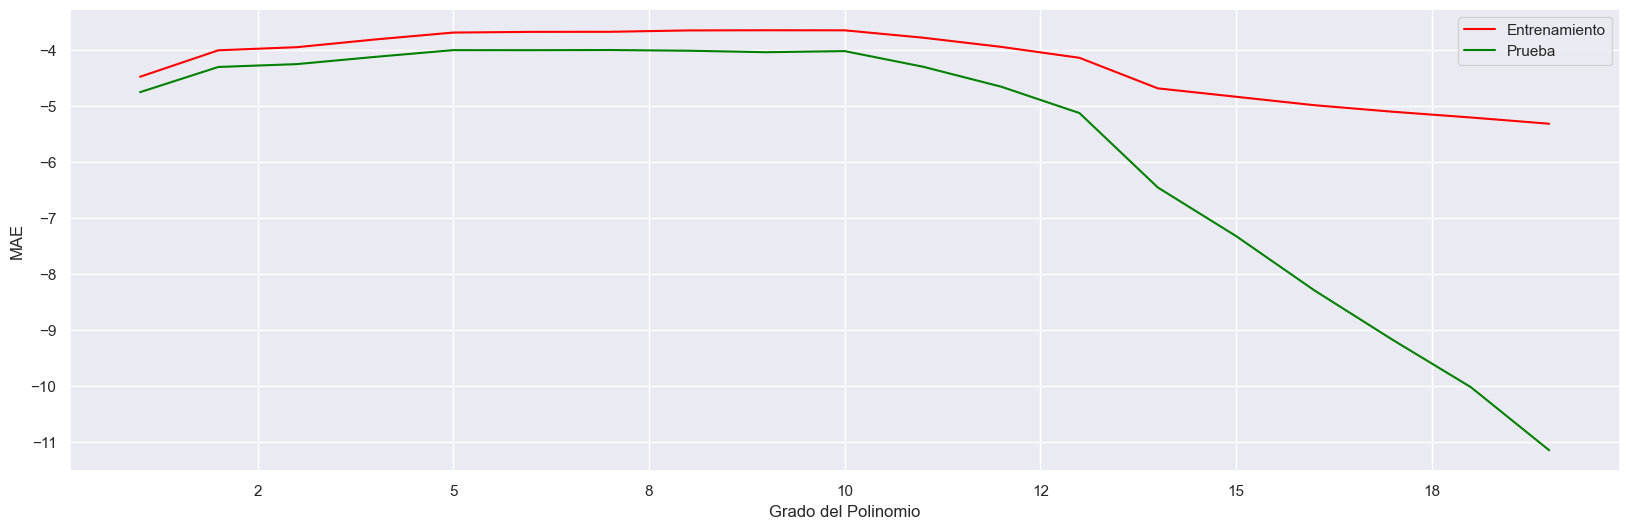

In [33]:
fig, ax = plt.subplots(figsize = (20, 6))
sns.lineplot(data = cv_results, x = "param_polynomialfeatures__degree", y = "mean_train_score", ax = ax, color = "red")
sns.lineplot(data = cv_results, x = "param_polynomialfeatures__degree", y = "mean_test_score", ax = ax, color = "green")

plt.xlabel("Grado del Polinomio")
plt.ylabel("MAE")
plt.legend(handles = ax.lines, labels = ["Entrenamiento", "Prueba"])
ax.xaxis.set_major_formatter("{x:.0f}")

In [34]:
modelo_cv.best_params_

{'polynomialfeatures__degree': 7}

In [35]:
cv_results2 = cv_results[["param_polynomialfeatures__degree", "mean_train_score", "mean_test_score", 
                          'std_test_score', 'std_train_score']].melt(id_vars = "param_polynomialfeatures__degree")
variables = cv_results2["variable"].str.split("_", expand = True).loc[:, [0, 1]]
cv_results2 = pd.concat([cv_results2.drop(columns = "variable"), variables], axis = 1)
cv_results2 = cv_results2.pivot(index = ["param_polynomialfeatures__degree", 1], columns = 0, values = "value").reset_index() 
cv_results2 = cv_results2.rename(columns = {1: "base"})
cv_results2.round(3)

c:\Users\Lucas\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


,param_polynomialfeatures__degree,base,mean,std
0,1,test,-4.752,0.838
1,1,train,-4.477,0.347
2,2,test,-4.302,0.978
3,2,train,-4.004,0.279
4,3,test,-4.252,0.959
5,3,train,-3.949,0.264
6,4,test,-4.123,0.909
7,4,train,-3.812,0.253
8,5,test,-4.002,1.001
9,5,train,-3.688,0.287


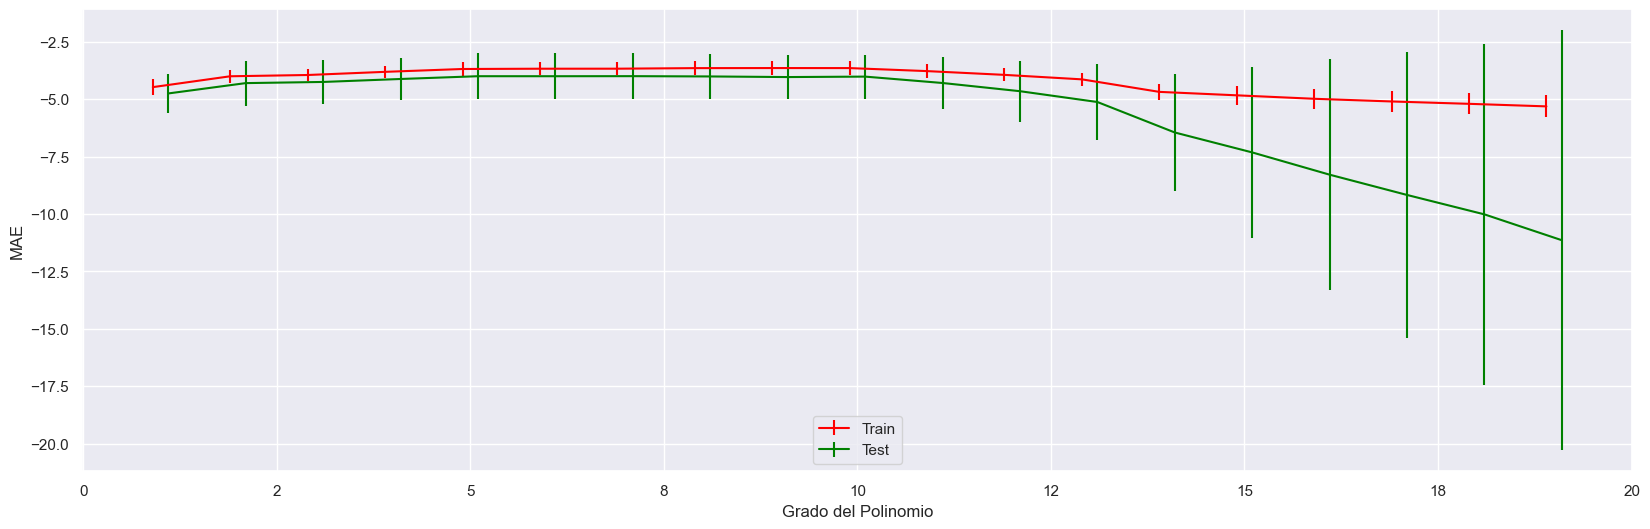

In [36]:
fig, ax = plt.subplots(figsize = (20, 6))

ax.errorbar(x = cv_results2.loc[cv_results2["base"] == "train", "param_polynomialfeatures__degree"] - 0.1, 
             y = cv_results2.loc[cv_results2["base"] == "train", "mean"],
             yerr = cv_results2.loc[cv_results2["base"] == "train", "std"],
             color = "red",
             label = "Train")

ax.errorbar(x = cv_results2.loc[cv_results2["base"] == "test", "param_polynomialfeatures__degree"] + 0.1, 
             y = cv_results2.loc[cv_results2["base"] == "test", "mean"],
             yerr = cv_results2.loc[cv_results2["base"] == "test", "std"],
             color = "green",
             label = "Test")

plt.xlabel("Grado del Polinomio")
plt.ylabel("MAE")
plt.legend(loc = "lower center")
ax.xaxis.set_major_formatter("{x:.0f}")

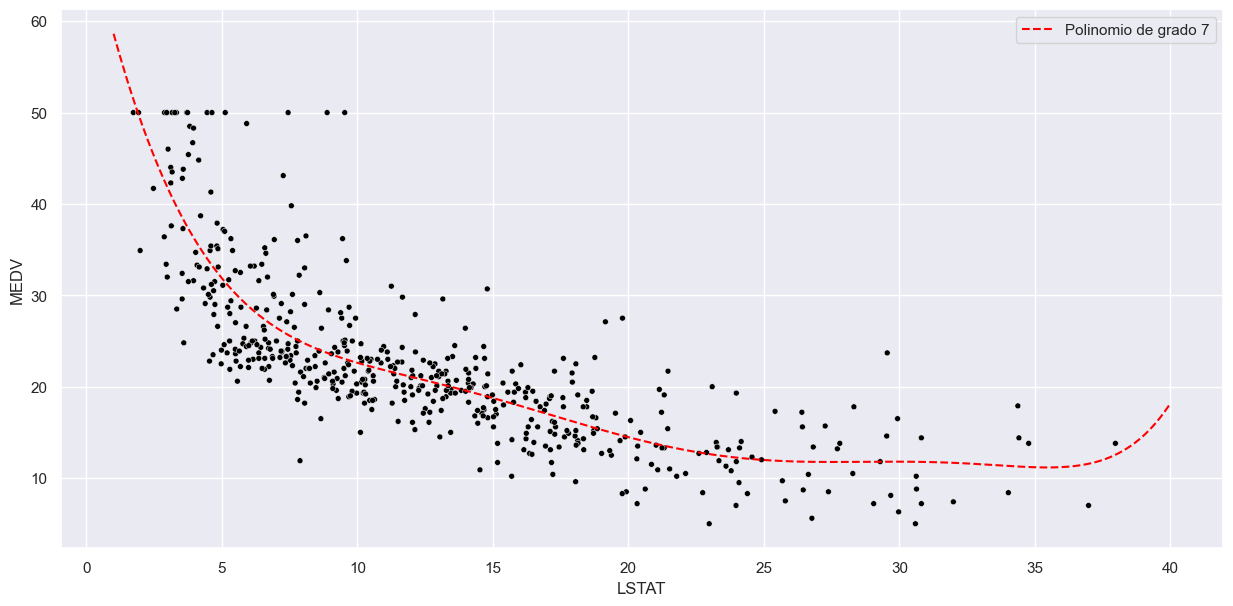

In [37]:
fig, ax = plt.subplots(figsize = (15, 7))
sns.scatterplot(data = boston, x = "LSTAT", y = "MEDV", color = 'black', size = 5, ax = ax, legend = False)

X_test = pd.DataFrame({"LSTAT": np.linspace(1, 40, boston.shape[0])})
y_test = modelo_cv.predict(X_test)
sns.lineplot(x = X_test["LSTAT"], y = y_test, label = 'Polinomio de grado 7', ax = ax, 
             color = "red", linestyle = "dashed")
plt.legend(loc = 'best')

In [38]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

y_real = np.array([12, 15, 20, 16, 20, 19, 16, 20, 16, 16])
y_predicho = np.array([14, 15, 18, 19, 25, 18, 12, 12, 15, 22])

# MSE
mean_squared_error(y_true = y_real, y_pred = y_predicho)

16.0

In [39]:
# RMSE
mean_squared_error(y_true = y_real, y_pred = y_predicho, squared = False)

4.0

In [40]:
# MAE
mean_absolute_error(y_true = y_real, y_pred = y_predicho)

3.2

In [41]:
# MAPE
mean_absolute_percentage_error(y_true = y_real, y_pred = y_predicho)

0.1844298245614035